# Automatic scoring of x-ray images

## 1. Preprocessing

Import dependencies

In [152]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# for train/test split
from sklearn.model_selection import train_test_split

# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer

# keras
from tensorflow.contrib.keras.python.keras import backend as K


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

Import csv

In [3]:
# df = pd.read_csv(filepath_or_buffer="/data/deepxray/data/rau_data/merged.csv")
df = pd.read_csv(filepath_or_buffer="/Volumes/deepxray/data/rau_data/merged.csv")
df = df.loc[df['body_part'].isin(["HAND_LEFT", "HAND_BOTH"])]
names = df["sop_iuid"].as_matrix()
df.head()

,id_x,patient_id,date_x,accession_no,scoring_dates,scoring_types,study_iuid,series_iuid,sop_iuid,body_part,...,foot_left_3,foot_left_4,foot_left_5,foot_right_1,foot_right_2,foot_right_3,foot_right_4,foot_right_5,rau_score,creation_date
1,2,1229,2008-08-02,570235,2008-08-02,rau,1.2.276.0.41.10.172.2.26.20080728.66320.2.570235,1.2.392.200046.100.2.1.200050.55991.2008072914...,1.2.392.200046.100.2.1.200050.55991.2008072914...,HAND_BOTH,...,5.0,5.0,15.0,0.0,0.0,5.0,10.0,10.0,33,2010-07-12
3,32486,5776,2006-05-11,1,2006-05-11,rau,1.2.840.113619.6.95.31.0.3.4.1.4099.13.1290030,1.3.46.670589.26.400122.2.20060329.163703.26797,1.2.840.114257.1.8062006.85706.1.1.1,HAND_LEFT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,10,2010-07-12
4,10,469,1983-11-09,NaN,2012-08-21,rau,1.2.276.0.7230010.3.1.2.0.22382.1278840446.382350,1.2.276.0.7230010.3.1.3.0.22382.1278840446.382349,1.2.276.0.7230010.3.1.4.0.22382.1278840446.382351,HAND_BOTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,2012-08-21
6,12,451,1987-02-13,NaN,2012-08-27,rau,1.2.276.0.7230010.3.1.2.0.22391.1278840447.356049,1.2.276.0.7230010.3.1.3.0.22400.1278840448.221664,1.2.276.0.7230010.3.1.4.0.22400.1278840448.221665,HAND_LEFT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62,2012-08-27
7,13,446,1987-08-11,NaN,2012-08-22,rau,1.2.276.0.7230010.3.1.2.0.22409.1278840449.122838,1.2.276.0.7230010.3.1.3.0.22409.1278840449.122837,1.2.276.0.7230010.3.1.4.0.22409.1278840449.122839,HAND_BOTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2012-08-22


Load images and labels into numpy arrays

In [144]:
# root = "/data"
root = "/Volumes"
dirname = "deepxray/joint_detection/output"

# function to remove black bars from image (preparation for histogram equalization)
def trim(im):
    # create a black image with the same size as original
    bg = Image.new(mode=im.mode, size=im.size, color=0)
    # get difference between image and background
    diff = ImageChops.difference(image1=im, image2=bg)
    # ensures, that the whole border gets removed (fuzzy border due to compression of jpg)
    diff = ImageChops.add(image1=diff, image2=diff, scale=2.0, offset=-100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

# function to load and preprocess the image
def preprocess_img(xray_name, joint_name):
    # folder name
    folder_name = "predictions_extract_" + joint_name
    # file name
    file_name = xray_name + "_" + joint_name + ".jpg"
    
    # read image
    image = Image.open(fp=os.path.join(root, dirname, folder_name, file_name))
    image_w, image_h = image.size
    
    # histogram normalization (remaps the image -> lightest pixel = 255, darkest pixel = 0)
    img = trim(image)
    img_w, img_h = img.size
    img = ImageOps.autocontrast(image=img)
    offset = (int((image_w - img_w) / 2), int((image_h - img_h) / 2))
    image.paste(img, offset)
    
    # turn into np array
    data = np.asarray(a=image, dtype="uint8")
    return(data)


In [181]:
def get_score(joint_number, index):
    score = df[joint_number].as_matrix()[index]
    return(score)

In [146]:
joint_numbers = ["hand_left_1", "hand_left_2", "hand_left_3", "hand_left_4", "hand_left_5", 
                 "hand_left_6", "hand_left_7", "hand_left_8", "hand_left_9", "hand_left_10"]
joint_names = ["pip5", "mcp5", "pip4", "mcp4", "pip3", "mcp3", "mcp2", "pip2", "mcp1", "pip1"]


for i in range(10):
    print(joint_numbers[i] + " -> " + joint_names[i])



hand_left_1 -> pip5
hand_left_2 -> mcp5
hand_left_3 -> pip4
hand_left_4 -> mcp4
hand_left_5 -> pip3
hand_left_6 -> mcp3
hand_left_7 -> mcp2
hand_left_8 -> pip2
hand_left_9 -> mcp1
hand_left_10 -> pip1


In [182]:
images = []
labels = []
n_img = names.shape[0]

for i, xray_name in enumerate(names):
    if (i % 100) == 0:
        clear_output()
        print("Importing images, {0:.2f} % finished".format(i/n_img*100))
        
    for joint in range(10):
        try:
            img = preprocess_img(xray_name, joint_names[joint])
        except Exception: 
            pass
        else:
            lbl = get_score(joint_numbers[joint], i)
            if np.isnan(lbl):
                continue
            else:
                images.append(img)
                labels.append(lbl)

Importing images, 99.79 % finished


In [183]:
images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)
#print(labels)

(100551, 150, 150)
(100551,)


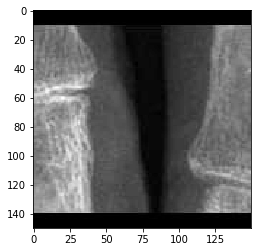

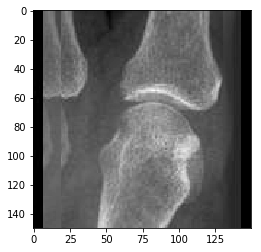

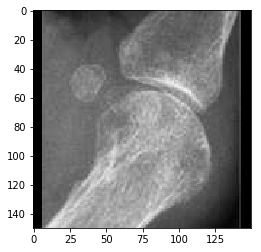

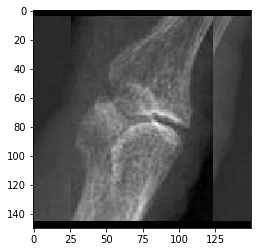

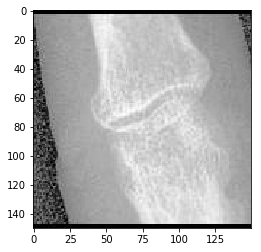

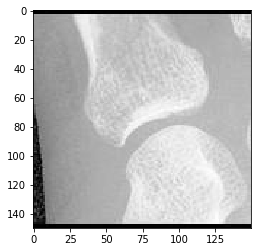

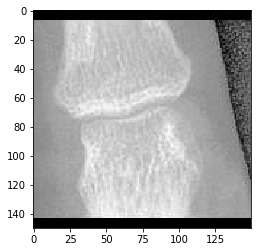

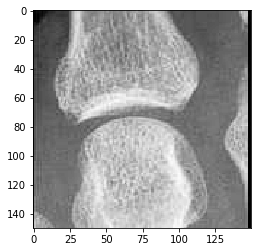

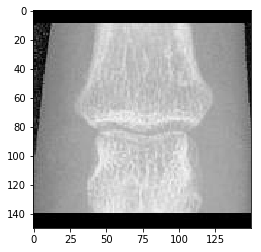

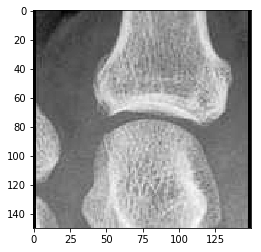

In [184]:
for i in range(10):    
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.show()

In [185]:
images = np.array(images)
#np.save(file="/data/joint_scoring/img_array.npy", arr=images)
np.save(file="/Users/janickrohrbach/Desktop/joint_scoring/img_array.npy", arr=images)

In [186]:
#images = np.load(file="/data/body_part_classification/img_array.npy")
images = np.load(file="/Users/janickrohrbach/Desktop/joint_scoring/img_array.npy")
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
#images = images/255.

In [187]:
# create four classes
labels[labels <= 25] = 0
labels[(labels > 25) & (labels <= 50)] = 1
labels[(labels > 50) & (labels <= 75)] = 2
labels[labels > 75] = 3

In [188]:
img_train, img_test, labels_train, labels_test = train_test_split(images, labels,
                                                                  test_size=0.25,
                                                                  random_state=1) #stratify=labels)

In [189]:
#np.save(file="/data/joint_scoring/img_train.npy", arr=img_train)
#np.save(file="/data/joint_scoring/img_test.npy", arr=img_test)
#np.save(file="/data/joint_scoring/labels_train.npy", arr=labels_train)
#np.save(file="/data/joint_scoring/labels_test.npy", arr=labels_test)

np.save(file="/Users/janickrohrbach/Desktop/joint_scoring/img_train.npy", arr=img_train)
np.save(file="/Users/janickrohrbach/Desktop/joint_scoring/img_test.npy", arr=img_test)
np.save(file="/Users/janickrohrbach/Desktop/joint_scoring/labels_train.npy", arr=labels_train)
np.save(file="/Users/janickrohrbach/Desktop/joint_scoring/labels_test.npy", arr=labels_test)

In [190]:
#img_train = np.load(file="/data/joint_scoring/img_train.npy")
#img_test = np.load(file="/data/joint_scoring/img_test.npy")
#labels_train = np.load(file="/data/joint_scoring/labels_train.npy")
#labels_test = np.load(file="/data/joint_scoring/labels_test.npy")

img_train = np.load(file="/Users/janickrohrbach/Desktop/joint_scoring/img_train.npy")
img_test = np.load(file="/Users/janickrohrbach/Desktop/joint_scoring/img_test.npy")
labels_train = np.load(file="/Users/janickrohrbach/Desktop/joint_scoring/labels_train.npy")
labels_test = np.load(file="/Users/janickrohrbach/Desktop/joint_scoring/labels_test.npy")

In [191]:
# one hot encode outputs
labels_train = LabelBinarizer().fit_transform(labels_train)
labels_test = LabelBinarizer().fit_transform(labels_test)
num_classes = labels_test.shape[1]
print(num_classes)

4
